<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/vit_withse_50epoch_apple_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 30.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=6)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)#32
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)#64
parser.add_argument("--nch_d", type = int, default=64)#64
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=50, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        #self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        self.file_list = glob.glob("/content/drive/MyDrive/Test/Apple**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)
        
      
    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        
        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        b, c, h, w = x.size()
        x = self.conv1(x) 

        #print(x.size())
       # x = self.linear_1(x).view(b, -1, h, w)
        #print(x.size())
        x = self.relu(x)
        #x = self.linear_2(x).view(b, -1, h, w)
        #print(x.size())


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)    

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 67/67 [04:00<00:00,  3.59s/it]


epoch: 0, lossD:1.2386618501214839, lossG:5.310407339636959,lossG_fake:2.272375450205447, lossG_real:3.038031891210755 ,equality:-0.7656564410053082


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:38.462371826171875,kid_mean:0.013878772035241127, kid_std:0.01938825473189354,kid_:(tensor(0.0139), tensor(0.0194))


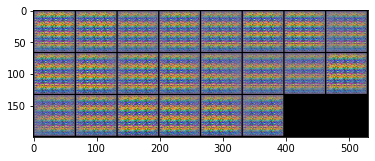

100%|██████████| 67/67 [00:23<00:00,  2.85it/s]


epoch: 1, lossD:0.35310982123239715, lossG:5.668482161279934,lossG_fake:2.3697108439545134, lossG_real:3.298771342234825 ,equality:-0.9290604982803115


evaluate:29.817346572875977,kid_mean:0.010080737993121147, kid_std:0.013140969909727573,kid_:(tensor(0.0101), tensor(0.0131))


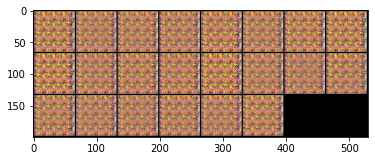

100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


epoch: 2, lossD:0.42311712143136493, lossG:5.904476094601759,lossG_fake:2.924622613992264, lossG_real:2.9798534717132794 ,equality:-0.055230857721015436


evaluate:39.3839111328125,kid_mean:0.0174618698656559, kid_std:0.02835649996995926,kid_:(tensor(0.0175), tensor(0.0284))


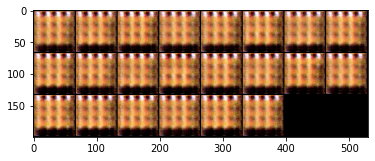

100%|██████████| 67/67 [00:23<00:00,  2.84it/s]


epoch: 3, lossD:0.4618995194114856, lossG:5.7239773380222605,lossG_fake:3.063482337923192, lossG_real:2.6604950036575543 ,equality:0.4029873342656378


evaluate:36.03962707519531,kid_mean:0.012406616471707821, kid_std:0.015049143694341183,kid_:(tensor(0.0124), tensor(0.0150))


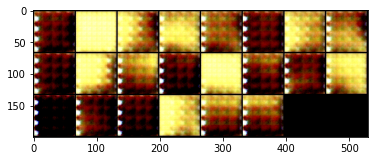

100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


epoch: 4, lossD:0.5768488022262481, lossG:5.173893416105812,lossG_fake:2.7802272412314344, lossG_real:2.393666157971567 ,equality:0.3865610832598674


evaluate:44.45293426513672,kid_mean:0.021984117105603218, kid_std:0.025851275771856308,kid_:(tensor(0.0220), tensor(0.0259))


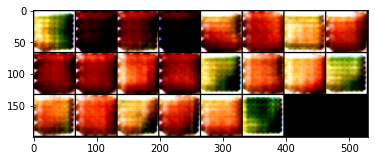

100%|██████████| 67/67 [00:24<00:00,  2.79it/s]


epoch: 5, lossD:0.8552123655134173, lossG:4.156757336943897,lossG_fake:2.180397389540032, lossG_real:1.9763599482934866 ,equality:0.20403744124654533


evaluate:41.09916687011719,kid_mean:0.017404796555638313, kid_std:0.021049926057457924,kid_:(tensor(0.0174), tensor(0.0210))


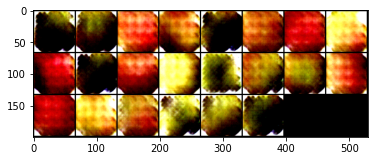

100%|██████████| 67/67 [00:23<00:00,  2.81it/s]


epoch: 6, lossD:1.3902895361629886, lossG:3.5027616593375135,lossG_fake:1.8455232844423892, lossG_real:1.6572383740055028 ,equality:0.18828491043688644


evaluate:38.854557037353516,kid_mean:0.019969122484326363, kid_std:0.024751659482717514,kid_:(tensor(0.0200), tensor(0.0248))


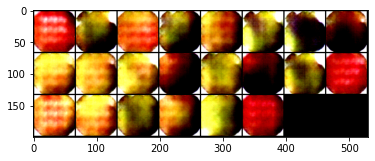

100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


epoch: 7, lossD:1.087153108262304, lossG:3.540841077690694,lossG_fake:1.8066202580039181, lossG_real:1.7342208214660189 ,equality:0.07239943653789926


evaluate:37.324745178222656,kid_mean:0.01238249521702528, kid_std:0.017812708392739296,kid_:(tensor(0.0124), tensor(0.0178))


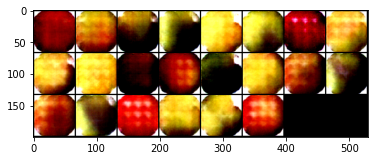

100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


epoch: 8, lossD:1.4103907595819503, lossG:3.415614384323803,lossG_fake:1.8085132419173398, lossG_real:1.6071011317310049 ,equality:0.20141211018633487


evaluate:37.392818450927734,kid_mean:0.01518839318305254, kid_std:0.022532498463988304,kid_:(tensor(0.0152), tensor(0.0225))


100%|██████████| 67/67 [00:23<00:00,  2.83it/s]


epoch: 9, lossD:1.2506581046688023, lossG:3.3806253511514237,lossG_fake:1.7902748424615433, lossG_real:1.5903504891182059 ,equality:0.19992435334333747


evaluate:39.219764709472656,kid_mean:0.016188059002161026, kid_std:0.02205638214945793,kid_:(tensor(0.0162), tensor(0.0221))


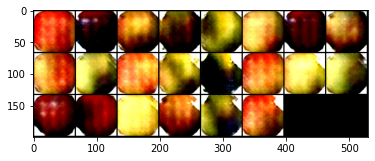

100%|██████████| 67/67 [00:23<00:00,  2.85it/s]


epoch: 10, lossD:1.220592522799079, lossG:3.685158355912166,lossG_fake:1.8872002407686035, lossG_real:1.797958110250644 ,equality:0.0892421305179596


evaluate:38.80037307739258,kid_mean:0.01557096466422081, kid_std:0.02122419700026512,kid_:(tensor(0.0156), tensor(0.0212))


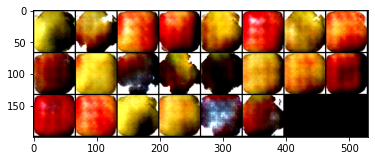

100%|██████████| 67/67 [00:23<00:00,  2.88it/s]


epoch: 11, lossD:0.9765058969383809, lossG:3.92620261391597,lossG_fake:2.0493756212405305, lossG_real:1.8768269989027906 ,equality:0.17254862233773993


evaluate:40.85348892211914,kid_mean:0.019350282847881317, kid_std:0.024942606687545776,kid_:(tensor(0.0194), tensor(0.0249))


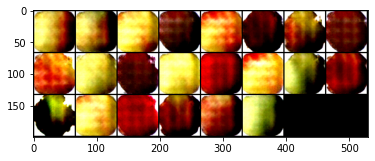

100%|██████████| 67/67 [00:22<00:00,  2.94it/s]


epoch: 12, lossD:1.218435464955088, lossG:3.797262291410076,lossG_fake:2.0416363157443147, lossG_real:1.755625986786031 ,equality:0.2860103289582836


evaluate:42.05835723876953,kid_mean:0.01914682425558567, kid_std:0.02649463526904583,kid_:(tensor(0.0191), tensor(0.0265))


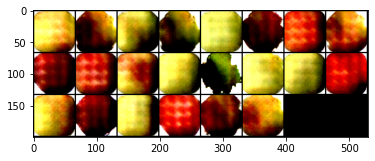

100%|██████████| 67/67 [00:23<00:00,  2.91it/s]


epoch: 13, lossD:1.2144928654628013, lossG:3.8296272434405427,lossG_fake:2.0040951878277222, lossG_real:1.8255320627297928 ,equality:0.17856312509792938


evaluate:39.57843017578125,kid_mean:0.01395027618855238, kid_std:0.022822756320238113,kid_:(tensor(0.0140), tensor(0.0228))


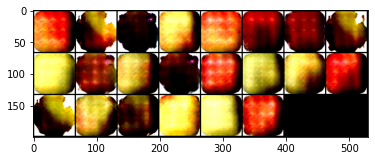

100%|██████████| 67/67 [00:22<00:00,  2.96it/s]


epoch: 14, lossD:1.2234131289062216, lossG:3.777860371034537,lossG_fake:1.9827967615269904, lossG_real:1.795063596163223 ,equality:0.18773316536376727


evaluate:39.10686111450195,kid_mean:0.012234935536980629, kid_std:0.016289645805954933,kid_:(tensor(0.0122), tensor(0.0163))


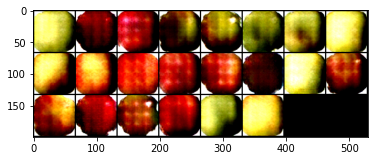

100%|██████████| 67/67 [00:23<00:00,  2.89it/s]


epoch: 15, lossD:1.377674932800122, lossG:3.525891940985153,lossG_fake:1.9082961447203337, lossG_real:1.6175957878134144 ,equality:0.2907003569069193


evaluate:39.74357986450195,kid_mean:0.014247152954339981, kid_std:0.019179290160536766,kid_:(tensor(0.0142), tensor(0.0192))


100%|██████████| 67/67 [00:22<00:00,  2.94it/s]


epoch: 16, lossD:1.3544636875835818, lossG:3.4415606705110466,lossG_fake:1.8048691625025735, lossG_real:1.636691501781122 ,equality:0.16817766072145135


evaluate:42.55913543701172,kid_mean:0.016624869778752327, kid_std:0.018911095336079597,kid_:(tensor(0.0166), tensor(0.0189))


100%|██████████| 67/67 [00:22<00:00,  2.92it/s]


epoch: 17, lossD:1.3170297999880207, lossG:3.4994992320217304,lossG_fake:1.7846525338158679, lossG_real:1.7148466857511606 ,equality:0.06980584806470724


evaluate:42.04826736450195,kid_mean:0.01793430745601654, kid_std:0.027043182402849197,kid_:(tensor(0.0179), tensor(0.0270))


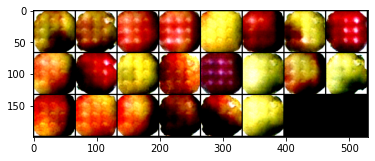

100%|██████████| 67/67 [00:22<00:00,  2.96it/s]


epoch: 18, lossD:1.3216707492942241, lossG:3.5608393576607775,lossG_fake:1.8974970445704105, lossG_real:1.6633423077526377 ,equality:0.23415473681777277


evaluate:43.2678108215332,kid_mean:0.018785487860441208, kid_std:0.029348039999604225,kid_:(tensor(0.0188), tensor(0.0293))


100%|██████████| 67/67 [00:22<00:00,  2.95it/s]


epoch: 19, lossD:1.337227143458466, lossG:3.4833337442198795,lossG_fake:1.8560037332684247, lossG_real:1.6273300065033471 ,equality:0.22867372676507758


evaluate:43.44245529174805,kid_mean:0.014607632532715797, kid_std:0.018922455608844757,kid_:(tensor(0.0146), tensor(0.0189))


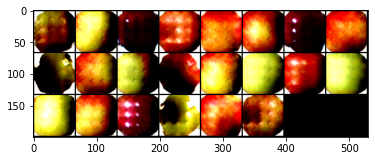

100%|██████████| 67/67 [00:22<00:00,  2.97it/s]


epoch: 20, lossD:1.2862511250510145, lossG:3.4995468125414493,lossG_fake:1.8332123872059494, lossG_real:1.6663344188857434 ,equality:0.16687796832020596


evaluate:44.39230728149414,kid_mean:0.015405552461743355, kid_std:0.021780068054795265,kid_:(tensor(0.0154), tensor(0.0218))


100%|██████████| 67/67 [00:22<00:00,  2.94it/s]


epoch: 21, lossD:1.201438729887578, lossG:3.685197171880238,lossG_fake:1.8947660237995547, lossG_real:1.7904311636490609 ,equality:0.10433486015049387


evaluate:44.328365325927734,kid_mean:0.021390052512288094, kid_std:0.024062393233180046,kid_:(tensor(0.0214), tensor(0.0241))


100%|██████████| 67/67 [00:23<00:00,  2.91it/s]


epoch: 22, lossD:1.2497540552224686, lossG:3.55591924510785,lossG_fake:1.8646278728300065, lossG_real:1.6912913753915189 ,equality:0.17333649743848767


evaluate:43.00584030151367,kid_mean:0.018092777580022812, kid_std:0.029974330216646194,kid_:(tensor(0.0181), tensor(0.0300))


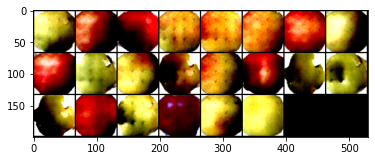

100%|██████████| 67/67 [00:23<00:00,  2.89it/s]


epoch: 23, lossD:1.2106734772226704, lossG:3.563871365874561,lossG_fake:1.878721012997983, lossG_real:1.6851503742274954 ,equality:0.19357063877048764


evaluate:43.04291534423828,kid_mean:0.015933973714709282, kid_std:0.020999565720558167,kid_:(tensor(0.0159), tensor(0.0210))


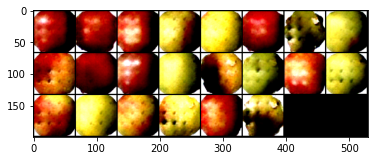

100%|██████████| 67/67 [00:23<00:00,  2.89it/s]


epoch: 24, lossD:1.1591713121577876, lossG:3.583883360250672,lossG_fake:1.8623671593950755, lossG_real:1.7215161950730566 ,equality:0.14085096432201882


evaluate:42.9820556640625,kid_mean:0.017085319384932518, kid_std:0.025535687804222107,kid_:(tensor(0.0171), tensor(0.0255))


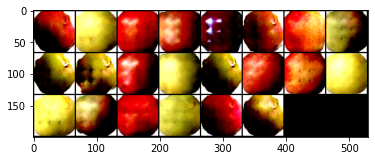

100%|██████████| 67/67 [00:23<00:00,  2.83it/s]


epoch: 25, lossD:1.1928374073398647, lossG:3.618153130830224,lossG_fake:1.89636456877438, lossG_real:1.7217885553836823 ,equality:0.17457601339069773


evaluate:43.47069549560547,kid_mean:0.02013295702636242, kid_std:0.026472028344869614,kid_:(tensor(0.0201), tensor(0.0265))


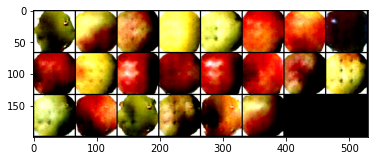

100%|██████████| 67/67 [00:24<00:00,  2.77it/s]


epoch: 26, lossD:1.1496720216167506, lossG:3.759900715813708,lossG_fake:1.943950483158453, lossG_real:1.8159502411066597 ,equality:0.1280002420517934


evaluate:44.161766052246094,kid_mean:0.018580852076411247, kid_std:0.024581968784332275,kid_:(tensor(0.0186), tensor(0.0246))


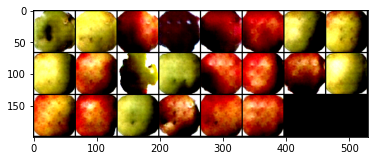

100%|██████████| 67/67 [00:23<00:00,  2.80it/s]


epoch: 27, lossD:1.2187520020933293, lossG:3.6065327587412366,lossG_fake:1.8706404540076185, lossG_real:1.7358922993958885 ,equality:0.13474815461172995


evaluate:43.72095489501953,kid_mean:0.02033556066453457, kid_std:0.025692380964756012,kid_:(tensor(0.0203), tensor(0.0257))


100%|██████████| 67/67 [00:23<00:00,  2.80it/s]


epoch: 28, lossD:1.125370304086315, lossG:3.67398473753858,lossG_fake:1.8948469971542927, lossG_real:1.7791377492805025 ,equality:0.11570924787379022


evaluate:43.06963348388672,kid_mean:0.01498728059232235, kid_std:0.02019571326673031,kid_:(tensor(0.0150), tensor(0.0202))


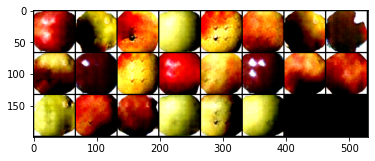

100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


epoch: 29, lossD:1.1725226863106686, lossG:3.643978311054742,lossG_fake:1.9171156109268985, lossG_real:1.7268627081344377 ,equality:0.19025290279246088


evaluate:43.50252914428711,kid_mean:0.014299252070486546, kid_std:0.0171823613345623,kid_:(tensor(0.0143), tensor(0.0172))


100%|██████████| 67/67 [00:23<00:00,  2.80it/s]


epoch: 30, lossD:1.1496274377872695, lossG:3.734088146864478,lossG_fake:1.9275646129650856, lossG_real:1.8065235321201496 ,equality:0.12104108084493603


evaluate:43.667503356933594,kid_mean:0.013991322368383408, kid_std:0.017831474542617798,kid_:(tensor(0.0140), tensor(0.0178))


100%|██████████| 67/67 [00:23<00:00,  2.81it/s]


epoch: 31, lossD:1.1094153078634348, lossG:3.6720987682911885,lossG_fake:1.894446223529417, lossG_real:1.7776525456513932 ,equality:0.11679367787802386


evaluate:43.36855697631836,kid_mean:0.01779559813439846, kid_std:0.023079318925738335,kid_:(tensor(0.0178), tensor(0.0231))


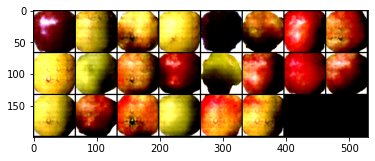

100%|██████████| 67/67 [00:24<00:00,  2.79it/s]


epoch: 32, lossD:1.0487186294883044, lossG:3.8911047835848223,lossG_fake:1.9765991764282114, lossG_real:1.914505603598125 ,equality:0.06209357283008643


evaluate:43.915767669677734,kid_mean:0.02391420118510723, kid_std:0.03137633204460144,kid_:(tensor(0.0239), tensor(0.0314))


100%|██████████| 67/67 [00:23<00:00,  2.80it/s]


epoch: 33, lossD:1.0747620125315083, lossG:3.840244506722066,lossG_fake:1.9661224662367978, lossG_real:1.8741220378164034 ,equality:0.09200042842039435


evaluate:43.708526611328125,kid_mean:0.02163085900247097, kid_std:0.023533223196864128,kid_:(tensor(0.0216), tensor(0.0235))


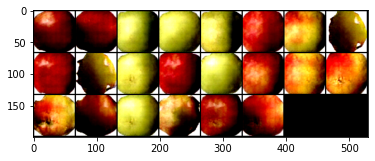

100%|██████████| 67/67 [00:24<00:00,  2.75it/s]


epoch: 34, lossD:1.03538624252846, lossG:3.84059231672714,lossG_fake:1.9447783836677892, lossG_real:1.895813922383892 ,equality:0.04896446128389731


evaluate:43.2398796081543,kid_mean:0.015873141586780548, kid_std:0.020996470004320145,kid_:(tensor(0.0159), tensor(0.0210))


100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


epoch: 35, lossD:0.9895200942879292, lossG:3.85705842900632,lossG_fake:1.978653336638835, lossG_real:1.87840509503635 ,equality:0.10024824160248502


evaluate:43.43647384643555,kid_mean:0.020710092037916183, kid_std:0.026489166542887688,kid_:(tensor(0.0207), tensor(0.0265))


100%|██████████| 67/67 [00:24<00:00,  2.78it/s]


epoch: 36, lossD:0.9736276998448727, lossG:3.94920159809625,lossG_fake:2.0856143022651104, lossG_real:1.8635872847108699 ,equality:0.22202701755424048


evaluate:43.268836975097656,kid_mean:0.022444481030106544, kid_std:0.030707823112607002,kid_:(tensor(0.0224), tensor(0.0307))


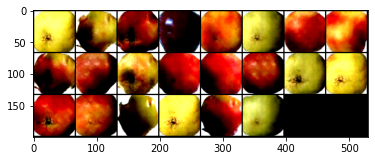

100%|██████████| 67/67 [00:23<00:00,  2.81it/s]


epoch: 37, lossD:0.939941430714593, lossG:4.02095599316839,lossG_fake:2.0501688238400133, lossG_real:1.9707871666595118 ,equality:0.0793816571805015


evaluate:42.88536071777344,kid_mean:0.016563670709729195, kid_std:0.024547474458813667,kid_:(tensor(0.0166), tensor(0.0245))


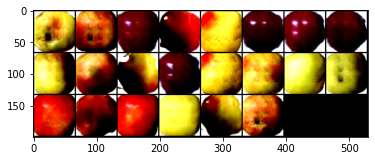

100%|██████████| 67/67 [00:23<00:00,  2.79it/s]


epoch: 38, lossD:0.9607013946593698, lossG:4.128414944036683,lossG_fake:2.0941334002053558, lossG_real:2.034281537603976 ,equality:0.05985186260137976


evaluate:42.095802307128906,kid_mean:0.017412610352039337, kid_std:0.021966449916362762,kid_:(tensor(0.0174), tensor(0.0220))


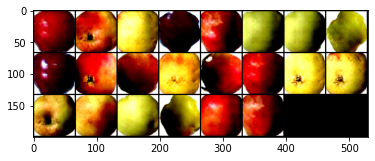

100%|██████████| 67/67 [00:24<00:00,  2.75it/s]


epoch: 39, lossD:0.9683707796815616, lossG:4.115025748067827,lossG_fake:2.1012229563584968, lossG_real:2.0138028059432758 ,equality:0.087420150415221


evaluate:41.604312896728516,kid_mean:0.020531365647912025, kid_std:0.02906430885195732,kid_:(tensor(0.0205), tensor(0.0291))


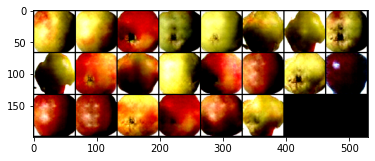

100%|██████████| 67/67 [00:23<00:00,  2.82it/s]


epoch: 40, lossD:0.8942146797233553, lossG:4.040842508202169,lossG_fake:2.041867726774358, lossG_real:1.998974796551377 ,equality:0.042892930222980796


evaluate:41.74176025390625,kid_mean:0.017921311780810356, kid_std:0.026872947812080383,kid_:(tensor(0.0179), tensor(0.0269))


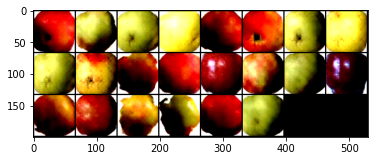

100%|██████████| 67/67 [00:23<00:00,  2.89it/s]


epoch: 41, lossD:0.8801088319785559, lossG:4.123657094898508,lossG_fake:2.141067344750931, lossG_real:1.9825897581541716 ,equality:0.15847758659675937


evaluate:41.093902587890625,kid_mean:0.018645070493221283, kid_std:0.0225530955940485,kid_:(tensor(0.0186), tensor(0.0226))


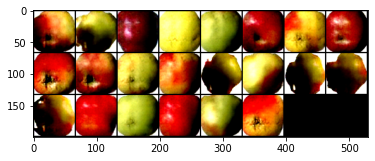

100%|██████████| 67/67 [00:23<00:00,  2.90it/s]


epoch: 42, lossD:0.9091008416752318, lossG:4.089396608409597,lossG_fake:2.050686132552019, lossG_real:2.0387104674061733 ,equality:0.011975665145845582


evaluate:40.836063385009766,kid_mean:0.01831355318427086, kid_std:0.024969499558210373,kid_:(tensor(0.0183), tensor(0.0250))


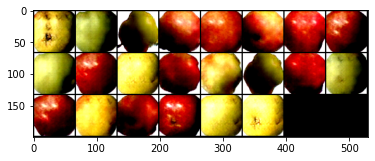

100%|██████████| 67/67 [00:22<00:00,  2.92it/s]


epoch: 43, lossD:0.7352906072428868, lossG:4.885518081152617,lossG_fake:2.4114341424472294, lossG_real:2.474083943598306 ,equality:-0.06264980115107655


evaluate:40.86858367919922,kid_mean:0.013288510031998158, kid_std:0.019782623276114464,kid_:(tensor(0.0133), tensor(0.0198))


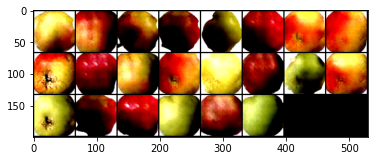

100%|██████████| 67/67 [00:22<00:00,  2.92it/s]


epoch: 44, lossD:0.88082440453234, lossG:4.198627582236902,lossG_fake:2.1716802484953583, lossG_real:2.0269473346311653 ,equality:0.14473291386419307


evaluate:40.92253494262695,kid_mean:0.01414129976183176, kid_std:0.021115485578775406,kid_:(tensor(0.0141), tensor(0.0211))


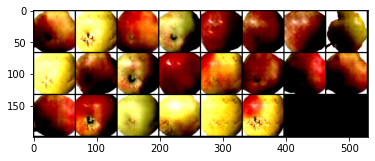

100%|██████████| 67/67 [00:22<00:00,  2.94it/s]


epoch: 45, lossD:0.8711327421131418, lossG:4.233873068396725,lossG_fake:2.159737336101817, lossG_real:2.074135730515665 ,equality:0.08560160558615193


evaluate:41.29098129272461,kid_mean:0.018831688910722733, kid_std:0.02716458961367607,kid_:(tensor(0.0188), tensor(0.0272))


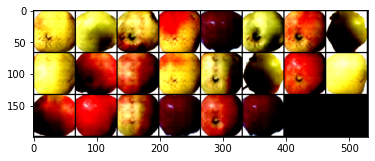

100%|██████████| 67/67 [00:22<00:00,  2.96it/s]


epoch: 46, lossD:0.8158247350756802, lossG:4.266687119185035,lossG_fake:2.183495242204239, lossG_real:2.0831918814289034 ,equality:0.10030336077533564


evaluate:41.051761627197266,kid_mean:0.013579599559307098, kid_std:0.020557140931487083,kid_:(tensor(0.0136), tensor(0.0206))


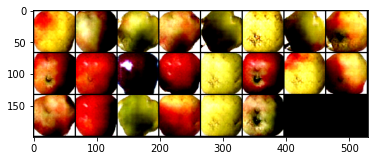

100%|██████████| 67/67 [00:23<00:00,  2.90it/s]


epoch: 47, lossD:0.8316369530425143, lossG:4.288839325976016,lossG_fake:2.201527239671394, lossG_real:2.087312076518785 ,equality:0.11421516315260893


evaluate:40.83859634399414,kid_mean:0.016025004908442497, kid_std:0.02238611876964569,kid_:(tensor(0.0160), tensor(0.0224))


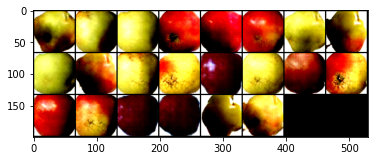

100%|██████████| 67/67 [00:22<00:00,  2.93it/s]


epoch: 48, lossD:0.8374417459786828, lossG:4.351034854775045,lossG_fake:2.209096635010705, lossG_real:2.1419381846242875 ,equality:0.06715845038641755


evaluate:40.57878112792969,kid_mean:0.018598223105072975, kid_std:0.026671027764678,kid_:(tensor(0.0186), tensor(0.0267))


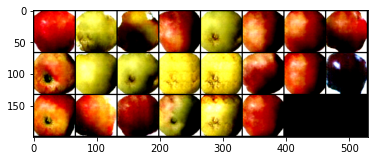

100%|██████████| 67/67 [00:22<00:00,  2.94it/s]


epoch: 49, lossD:0.8283831975353297, lossG:4.359764935365364,lossG_fake:2.2093148071374467, lossG_real:2.150450091753433 ,equality:0.05886471538401361


evaluate:40.900028228759766,kid_mean:0.016815997660160065, kid_std:0.025934530422091484,kid_:(tensor(0.0168), tensor(0.0259))


In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

In [45]:
plt.plot(raw_lossesD)

In [46]:
plt.plot(raw_lossesG)

In [47]:
plt.plot(lossesD)

In [48]:
plt.plot(lossesG)

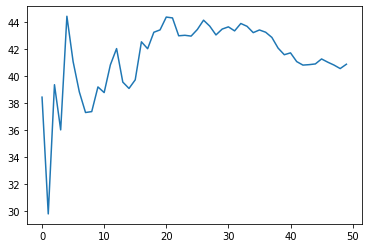

In [49]:
plt.plot(fid_)

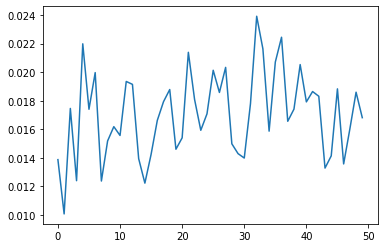

In [50]:
plt.plot(kid_mean_)

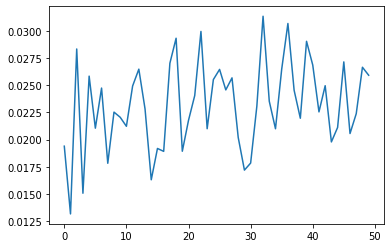

In [51]:
plt.plot(kid_std_)

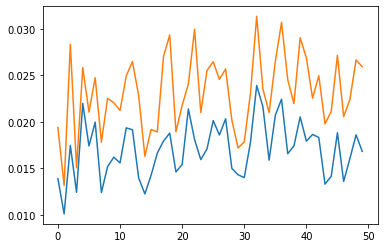

In [52]:
plt.plot(kid_score)

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0173), tensor(0.0212))